In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy import stats
import os
import time
import matplotlib.pyplot as plt  
import random

from sklearn.metrics import precision_recall_curve, auc
from sklearn import preprocessing
from skbio.diversity import alpha_diversity
from skbio.stats.distance import DistanceMatrix
from numpy import zeros
from skbio.stats.ordination import pcoa

import geopandas as gpd
from shapely.geometry import Point
from scipy.spatial import cKDTree
import georasters as gr

import warnings
warnings.filterwarnings('ignore')

/home/zrimec/miniconda3/envs/plastics/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysalnext` package. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


In [2]:
# variables

e_cut = 1e-16
col = 'group_id'
corr_f = stats.spearmanr
palett = sns.color_palette("Paired",8)
label_hits = 'Num. plastic degrading enzymes'
label_plast = 'Num. degradable plastic types'
label_hits_n = 'Num. plastic\ndegrading enzymes'
label_plast_n = 'Num. degradable\nplastic types'

# plastics as additional
additives = ['PA','phthalate','DBP','TP']
depth_order=['SRF','DCM','MES']
ocean_order=['MS','RS','IO','SO','SAO','NAO','SPO','NPO']
ocean_long={'MS':'Mediterranean Sea','RS':'Red Sea',
            'IO':'Ionian Sea','SO':'Southern Ocean',
            'SAO':'South Atlantic Ocean','NAO':'North Atlantic Ocean',
            'SPO':'South Pacific Ocean','NPO':'North Pacific Ocean'}
df_ocean = pd.DataFrame(ocean_long.keys(),columns=['short'])
df_ocean['long'] = ocean_long.values()
df_ocean.set_index('short').loc[ocean_order].values

col_env = ['8_Latitude of event (Latitude)',
           '9_Longitude of event (Longitude)',
           '18_Depth, reference [m] (Depth ref)',
             '19_Conductivity [mS/cm] (Cond)',
             '20_Salinity (Sal)', 
             '21_Temperature, water, potential [°C] (Tpot)',
             '22_Density, sigma-theta (0) [kg/m', 
             '23_Oxygen [µmol/kg] (OXYGEN)',
             '25_Nitrate [µmol/l] ([NO3]-)',
             '27_Phosphate [µmol/l] ([PO4]3-)',
             '28_Nitrate and Nitrite [µmol/l] ([NO3]- + [NO2]-)',
             '29_Silicate [µmol/l] (Si(OH)4)']

dic_env = dict(zip(col_env, ['Nitrate_nitrite' if '28' in x else 
                             x.split('_')[1].split(' ')[0].replace(',','') 
                             for x in col_env]))
# add units
dic_env2 = {'8_Latitude of event (Latitude)': 'Latitude [°]',
 '9_Longitude of event (Longitude)': 'Longitude [°]',
 '18_Depth, reference [m] (Depth ref)': 'Depth [m]',
 '19_Conductivity [mS/cm] (Cond)': 'Conductivity [mS/cm]',
 '20_Salinity (Sal)': 'Salinity',
 '21_Temperature, water, potential [°C] (Tpot)': 'Temperature [°C]',
 '22_Density, sigma-theta (0) [kg/m': 'Density [kg/m]',
 '23_Oxygen [µmol/kg] (OXYGEN)': 'Oxygen [µmol/kg]',
 '25_Nitrate [µmol/l] ([NO3]-)': 'Nitrate [µmol/l]',
 '27_Phosphate [µmol/l] ([PO4]3-)': 'Phosphate [µmol/l]',
 '28_Nitrate and Nitrite [µmol/l] ([NO3]- + [NO2]-)': 'Nitrate_nitrite [µmol/l]',
 '29_Silicate [µmol/l] (Si(OH)4)': 'Silicate [µmol/l]'}

In [3]:
# functions

def get_prc(df_hits,plastic,plot=False):
    precision, recall, thresholds = precision_recall_curve(df_hits.label.values,
                       df_hits.score.values,
                       pos_label='tara')
    prc_auc = auc(recall,precision)

    if plot==True:
        plt.plot(recall, precision, color='darkorange',
                 lw=2, label='PRC curve (area = %0.2f)' % prc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc="lower right")
        plt.title(plastic)
        plt.show()
    
    return precision, recall, thresholds, prc_auc
    
def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, p = corr_f(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'r = {r:.3f}, p = {p:.1e}', xy=(.1, .9), xycoords=ax.transAxes)
    
def fix_pvals(x):
    if x < 1e-16:
        x=1e-16
    return x

# merge on closest value
# https://gis.stackexchange.com/questions/222315/geopandas-find-nearest-point-in-other-dataframe
def ckdnearest(gdA, gdB):
    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdf = pd.concat(
        [gdA.reset_index(drop=True), gdB.loc[idx, gdB.columns != 'geometry'].reset_index(drop=True),
         pd.Series(dist, name='dist')], axis=1)
    return gdf

def dframe_stack_list(ins,col,typ='float32'):
    df = ins.copy(deep=True)
    s = df[col].apply(lambda x: pd.Series(list(x)),1).stack().astype(typ)
    s.index = s.index.droplevel(-1)
    s.name = col
    del df[col]
    df = df.join(s)
    return df

#https://stackoverflow.com/questions/30657453/fitting-a-straight-line-to-a-log-log-curve-in-matplotlib
def powerfit(x, y, xnew, epsilon=False):
    """line fitting on log-log scale"""
    if epsilon==True:
        k, m = np.polyfit(np.log(x+1e-8), np.log(y+1e-8), 1)
    else:
        k, m = np.polyfit(np.log(x), np.log(y), 1)
    return np.exp(m) * xnew**(k)

#http://readiab.org/book/latest/3/1
def bray_curtis_distance(table, sample1_id, sample2_id):
    numerator = 0
    denominator = 0
    sample1_counts = table[sample1_id]
    sample2_counts = table[sample2_id]
    for sample1_count, sample2_count in zip(sample1_counts, sample2_counts):
        numerator += abs(sample1_count - sample2_count)
        denominator += sample1_count + sample2_count
    if denominator == 0:
        denominator += 1e-8
    return numerator / denominator

def table_to_distances(table, pairwise_distance_fn):
    sample_ids = table.columns
    num_samples = len(sample_ids)
    data = zeros((num_samples, num_samples))
    for i, sample1_id in enumerate(sample_ids):
        for j, sample2_id in enumerate(sample_ids[:i]):
            data[i,j] = data[j,i] = pairwise_distance_fn(table, sample1_id, sample2_id)
    return DistanceMatrix(data, sample_ids)

def normalize(xx):
    mn = min(xx)
    mx = max(xx)
    return np.array([(x-mn)/(mx-mn) for x in xx])

# Load data

In [4]:
# metadata

tara_metadata = (pd
                 .read_excel('../data/Sunagawa_TableS1.xlsx',sheet_name='tableS1')
                 .rename(columns={'INSDC sample accession number(s)':'inscd_id',
                                  'INSDC run accession number(s)':'run',
                                  'Latitude [degrees North]':'latitude',
                                  'Longitude [degrees East]':'longitude'})
                )
tara_metadata['sample_id'] = (tara_metadata['Sample label [TARA_station#_environmental-feature_size-fraction]']
                              .apply(lambda x: ''.join(x.split('_')[:2]))
                             )
tara_metadata['depth_id'] = (tara_metadata['Sample label [TARA_station#_environmental-feature_size-fraction]']
                              .apply(lambda x: x.split('_')[2])
                             )
tara_metadata['depth_id2'] = (tara_metadata['Sample label [TARA_station#_environmental-feature_size-fraction]']
                              .apply(lambda x: x.split('_')[2])
                             )
tara_metadata['size_id'] = (tara_metadata['Sample label [TARA_station#_environmental-feature_size-fraction]']
                              .apply(lambda x: ''.join(x.split('_')[3:]))
                             )

# rename MIX as DCM 
tara_metadata.loc[tara_metadata.depth_id=='MIX','depth_id'] = 'DCM'

print(tara_metadata.sample_id.unique().shape)
print(tara_metadata.shape)
tara_metadata.head()

# location grouping variables
marine_groups = ['Ocean and sea regions (IHO General Sea Areas 1953) [MRGID registered at www.marineregions.com]',
    'Marine provinces  (Longhurst 2007)',
    'Biogeographic biomes (Longhurst 2007)']

# define ocean, ocean province, biome
tara_metadata['ocean'] = tara_metadata[marine_groups[0]].apply(lambda x: x.split(')')[0][1:])
tara_metadata['ocean_province'] = tara_metadata[marine_groups[1]].apply(lambda x: x.split(')')[0][1:])
tara_metadata['biome'] = tara_metadata[marine_groups[2]]
tara_metadata['ocean_long'] = tara_metadata.ocean.map(ocean_long)
tara_metadata['group_id'] = tara_metadata.run

# prokaryote enriched fraction
print(tara_metadata[tara_metadata['size_id'].isin(['0.22-1.6','0.22-3'])].shape)
print(tara_metadata[(tara_metadata.size_id.isin(['0.22-1.6','0.22-3']))&
              (tara_metadata.depth_id=='SRF')].shape)

# no pooling is required with this partitioning
(tara_metadata[(tara_metadata.size_id.isin(['0.22-1.6','0.22-3']))&
              (tara_metadata.depth_id=='SRF')]
 .groupby('sample_id')['Size fraction upper threshold [micrometre]']
 .apply(lambda x: len(list(x)))
 .describe()
)
# replace id with the one we are using
to_replace = {'ERS492821|ERS492814':'ERS492814'}
tara_metadata = tara_metadata.replace({'inscd_id':to_replace})

tara_sample_map = pd.read_csv('../data/tara-assembly-sample-mapping.txt'
                              ,sep='\t',names=['sample_id','inscd_id','samea_id'])

tara_sample_map['sample_id_short'] = (tara_sample_map
                                      .sample_id
                                      .apply(lambda x: x[:6])
                                     )
tara_sample_map

# load more env data 
cols = (pd.read_csv('../data/tara_env_column_names.tab',sep='*',
           usecols=[0],header=None)[0]
        .str.strip(' ') # drop trailing whitespace
        .reset_index()
       )
cols = (cols['index'].apply(str)+'_'+cols[0])

df_env = (pd
          .read_csv('../data/output_pangea_sample_identifiers.tab',sep='\t',names=cols)
          .merge(tara_metadata[['inscd_id','PANGAEA sample identifier','group_id']],
                left_on='0_Sample ID (Sample ID)',
                 right_on='PANGAEA sample identifier',how='left')
          )
print(df_env.shape)
df_env.head()

(69,)
(243, 21)
(139, 26)
(63, 26)
(243, 66)


,0_Sample ID (Sample ID),1_Basis of event (Basis),2_Campaign of event (Campaign),3_Station label (Station),4_Event label (Event),5_Optional event label (Event 2),6_Method/Device of event (Method/Device),7_Date/Time of event (Date/Time),8_Latitude of event (Latitude),9_Longitude of event (Longitude),...,56_Sunshine duration [min] (SSD),"57_Geostrophic velocity, longitudinal [cm/s] (u)","58_Geostrophic velocity, latitudinal [cm/s] (v)",59_Okubo-Weiss parameter (OW),60_Maximum Lyapunov exponent [1/day] (MLE),"61_Sea surface temperature gradient, horizontal [°C/100 km] (SST grad h)",62_Residence time [days] (RT),inscd_id,PANGAEA sample identifier,group_id
0,TARA_X000000368,SV Tara,TARA_20090913Z,TARA_004,TARA_20090915T1800Z_004_EVENT_PUMP,[day] [deep chlorophyll maximum layer (ENVO:01...,High Volume Peristaltic Pump,2009-09-15T18:00,36.5533,-6.5669,...,745.0,2.387,0.593,0.007,0.023,NaN,NaN,ERS487936,TARA_X000000368,ERR598950|ERR599095
1,TARA_Y200000002,SV Tara,TARA_20090913Z,TARA_004,TARA_20090915T1130Z_004_EVENT_PUMP,[day] [surface water layer (ENVO:00002042)],High Volume Peristaltic Pump,2009-09-15T11:30,36.5533,-6.5669,...,745.0,2.387,0.593,0.007,0.023,NaN,NaN,ERS487899,TARA_Y200000002,ERR598955|ERR599003
2,TARA_A200000159,SV Tara,TARA_20090919Z,TARA_007,TARA_20090923T1608Z_007_EVENT_PUMP,[day] [deep chlorophyll maximum layer (ENVO:01...,High Volume Peristaltic Pump,2009-09-23T16:08,37.0541,1.9478,...,727.0,29.111,-8.579,-0.794,0.000,NaN,NaN,ERS477953,TARA_A200000159,ERR315856
3,TARA_A200000113,SV Tara,TARA_20090919Z,TARA_007,TARA_20090923T1250Z_007_EVENT_PUMP,[day] [surface water layer (ENVO:00002042)],High Volume Peristaltic Pump,2009-09-23T12:50,37.0510,1.9378,...,727.0,29.111,-8.579,-0.794,0.000,NaN,NaN,ERS477931,TARA_A200000113,ERR315857
4,TARA_X000001036,SV Tara,TARA_20090926Z,TARA_009,TARA_20090928T1659Z_009_EVENT_PUMP,[day] [deep chlorophyll maximum layer (ENVO:01...,High Volume Peristaltic Pump,2009-09-28T16:59,39.0609,5.9422,...,714.0,-16.066,8.651,-0.774,0.083,24.398,24.74,ERS488147,TARA_X000001036,ERR594315|ERR594329


In [5]:
# load

dfs = pd.read_csv('../data/tara_assemblies_parsed.csv')
print(dfs.shape)

dfs['sample_id'] = (dfs.target_name
                     .apply(lambda x: x.split('|')[1][:6])
                     #.apply(lambda x: x.split('_')[0].split('.')[0])
                    )
dfs = (dfs
        .merge(tara_sample_map.drop(columns='sample_id'),
                        left_on='sample_id',
                        right_on='sample_id_short',
                        how='left')
      .drop(columns=['sample_id_short'])
      .merge(tara_metadata[['inscd_id','run','depth_id','size_id','ocean']],
             on='inscd_id',how='left')
     )

# prokaryote enriched fraction
tmp = (tara_metadata[(tara_metadata.size_id.isin(['0.22-1.6','0.22-3']))]
       .inscd_id)

dfs = dfs[dfs.inscd_id.isin(tmp)].rename(columns={'e-value':'e_value'})
print(dfs.inscd_id.unique().shape)
print(dfs.shape)

# mark additives
dfs['additive'] = False
dfs.loc[dfs.plastic.isin(additives),'additive'] = True
dfs['group_id'] = dfs.run

# subset
dfs = dfs.query('e_value<=@e_cut')
print(dfs.shape)

(17681, 22)
(139,)
(12484, 29)
(11906, 31)


In [6]:
# for text
(tara_metadata
 [(tara_metadata.size_id.isin(['0.22-1.6','0.22-3']))]
 ['Station identifier [TARA_station#]']
 .unique().shape
)

(67,)

# Analysis

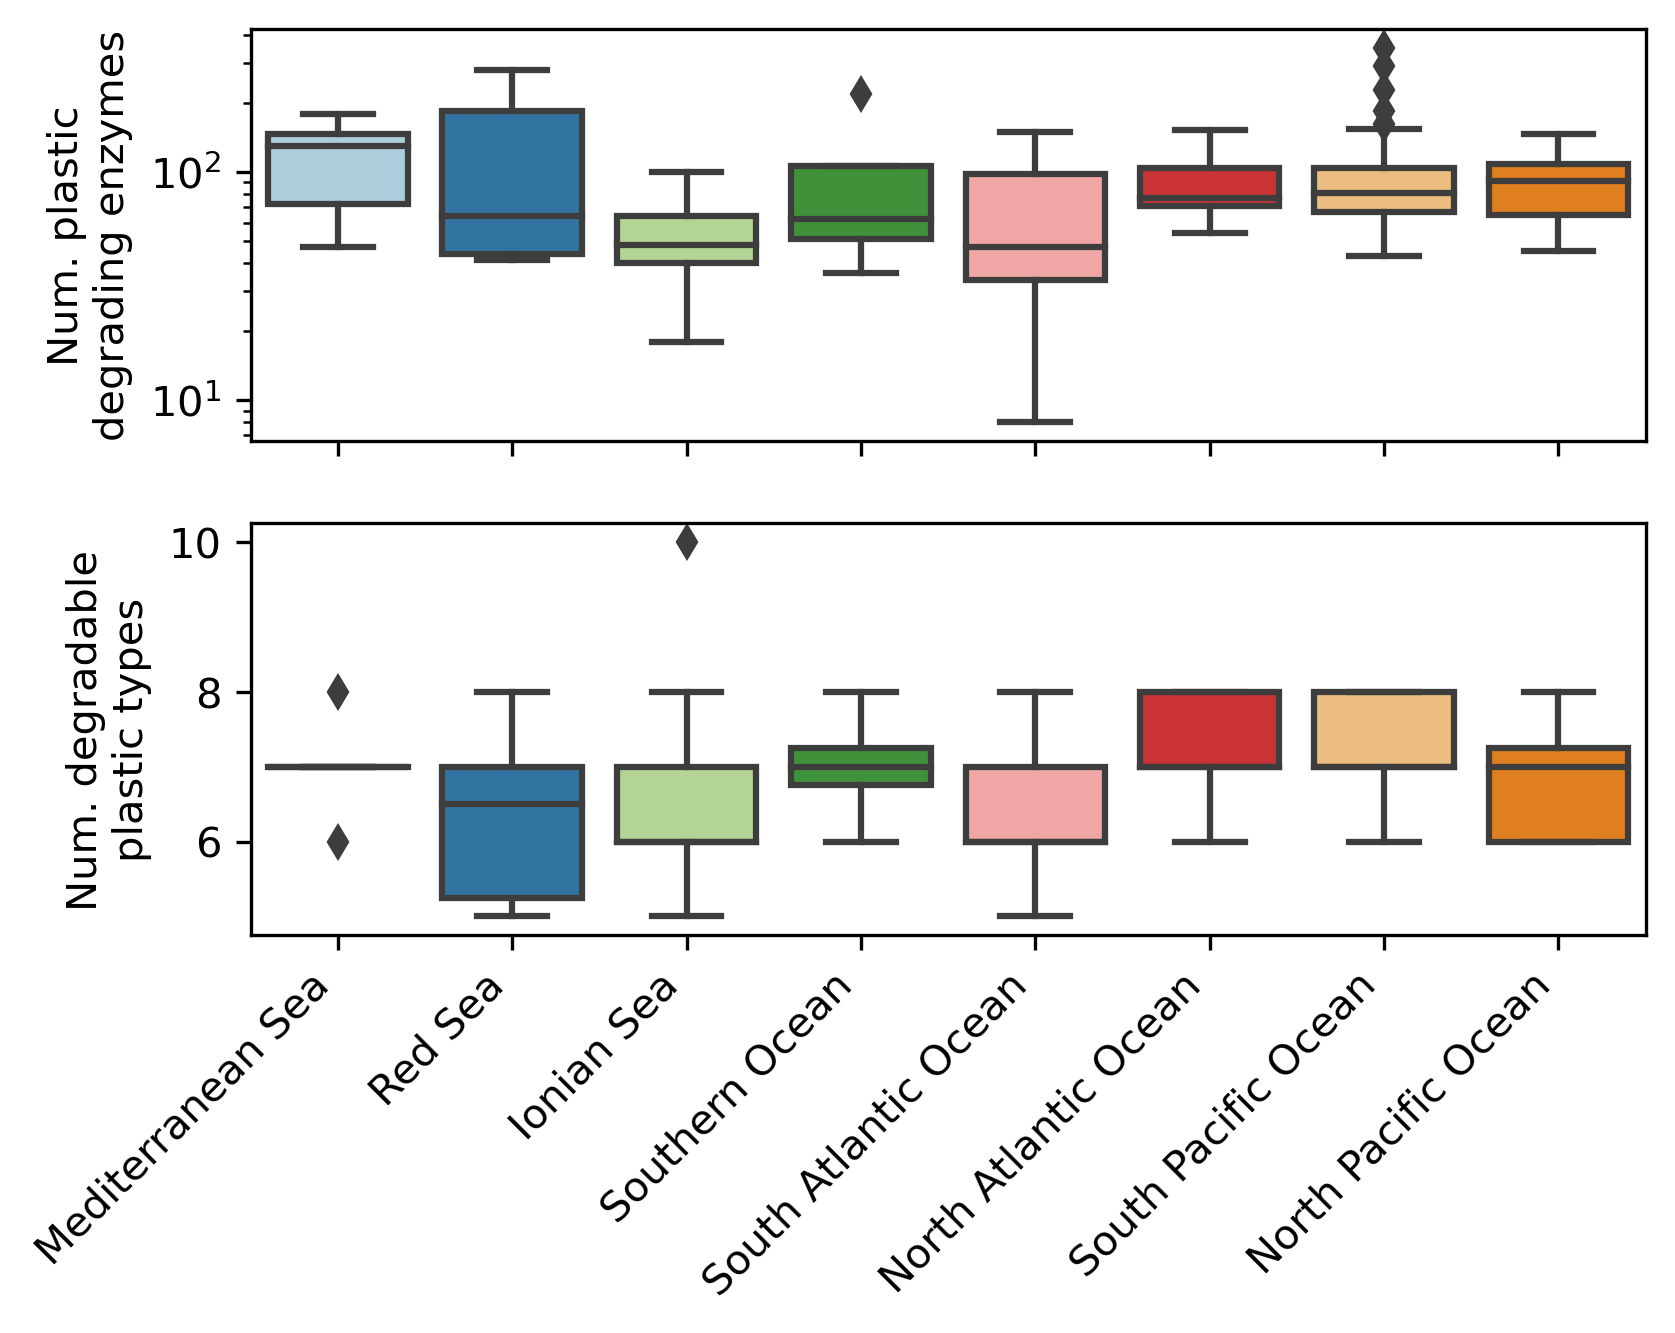

In [7]:
# per ocean region - separate plots
# average per sampling site and variability
# make long df and use facet grid
dfs1 = dfs.merge(tara_metadata[['ocean','ocean_long']].drop_duplicates(),
                 on='ocean',how='left').drop(columns=['ocean']).rename(columns={'ocean_long':'ocean'})
col2 = 'ocean'

tmp = []
tmp.append(dfs1.groupby([col2,col]).plastic.nunique().rename('value').reset_index())
tmp[-1]['ylabel'] = 'Num. plast.'
tmp.append(dfs1.groupby([col2,col]).hmm_model.nunique().rename('value').reset_index())
tmp[-1]['ylabel'] = 'Num. hmms'
tmp.append(dfs1.groupby([col2,col]).target_name.count().rename('value').reset_index())
tmp[-1]['ylabel'] = 'Num. hits'

# via subplots
mpl.rcParams['figure.dpi'] = 300
fig, axs = plt.subplots(2,figsize=(6,4))

pal = sns.color_palette()
dic = dict(zip(ocean_order, pal))
dic

k=0
for what in ['Num. hits','Num. plast.']:#pd.concat(tmp).ylabel.unique():
    sns.boxplot(data=pd.concat(tmp).query('ylabel==@what'),
                x=col2,y='value',
                order=[x[0] for x in df_ocean.set_index('short').loc[ocean_order].values],
                ax=axs[k],
                palette=palett
               )
    if what == 'Num. hits':
        axs[k].set_ylabel(label_hits_n)
    else:
        axs[k].set_ylabel(label_plast_n)
    k+=1
    
axs[-1].get_shared_x_axes().join(*axs)
[axs[k].set_xticklabels([]) for k in range(1)]
[axs[k].set_xlabel('') for k in range(1)]
plt.xticks(rotation=45,ha='right')
plt.xlabel('')
axs[0].set_yscale('log')
#axs[0].set_title('Ocean')
# NOTE: median value for red sea is in middle as by definition it falls just between the 2 full values
plt.show()

In [8]:
# all vs the rest significance test
test = stats.ranksums
what = 'Num. hits'
data = pd.concat(tmp).query('ylabel==@what')
data

ranksum = []
for var in data.ocean.unique():
    r,p = test(data.query('ocean==@var').value,
         data.query('ocean!=@var').value
        )
    n = data.query('ocean==@var').shape[0]
    ranksum.append([var,p,n])
pd.DataFrame(ranksum,columns=['ocean','p','n'])

,ocean,p,n
0,Ionian Sea,0.000002,27
1,Mediterranean Sea,0.007674,12
2,North Atlantic Ocean,0.144683,21
3,North Pacific Ocean,0.200435,16
4,Red Sea,1.000000,6
5,South Atlantic Ocean,0.049401,19
6,South Pacific Ocean,0.028682,34
7,Southern Ocean,0.691469,4


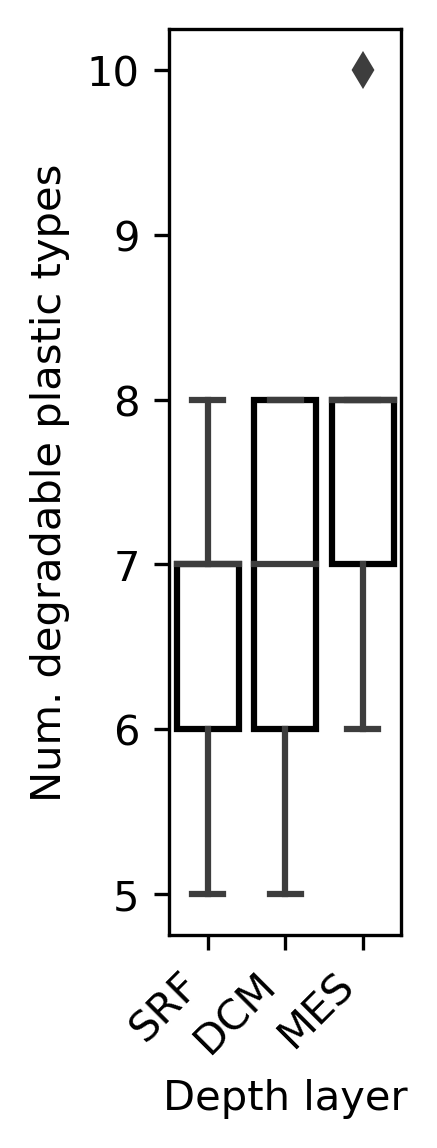

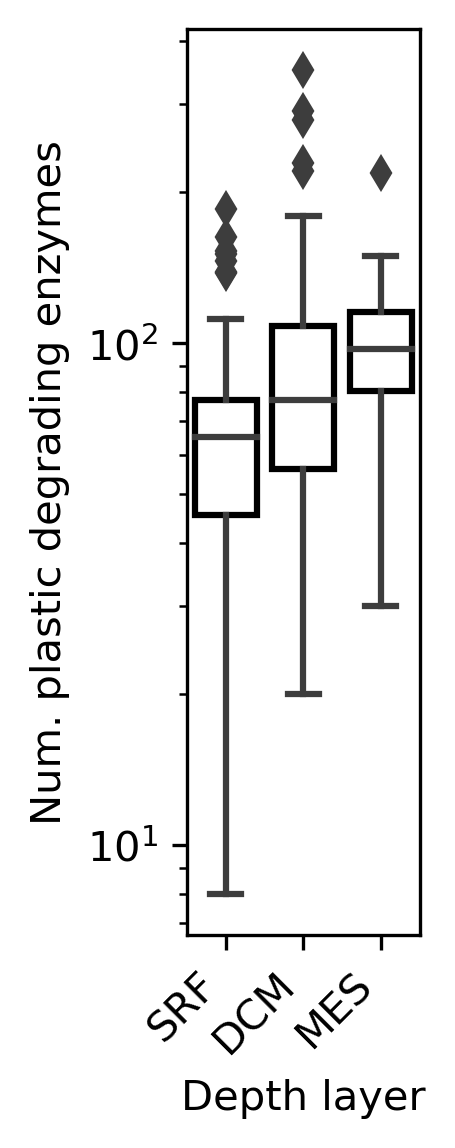

In [9]:
# per depth layer

tmp = []
tmp.append(dfs1.groupby(col).plastic.nunique().rename('value').reset_index())
tmp[-1]['ylabel'] = 'Num. plast.'
tmp.append(dfs1.groupby(col).hmm_model.nunique().rename('value').reset_index())
tmp[-1]['ylabel'] = 'Num. hmms'
tmp.append(dfs1.groupby(col).target_name.count().rename('value').reset_index())
tmp[-1]['ylabel'] = 'Num. hits'

# make separate plots
for coll in ["Num. plast.","Num. hits"]:
    plt.figure(figsize=(1,4))
    ax=sns.boxplot(data=pd.concat(tmp)
            .merge(tara_metadata[[col,'depth_id']],
                     on=col,how='left')
                .query('ylabel==@coll'),
               y='value',x='depth_id',
                   order=['SRF','DCM','MES']
               )
    if coll == 'Num. hits':
        plt.ylabel(label_hits)
        plt.yscale('log')
    else:
        plt.ylabel(label_plast)
    plt.xticks(rotation=45,ha='right')
    plt.xlabel('Depth layer')
    
    for i,box in enumerate(ax.artists):
        box.set_edgecolor('black')
        box.set_facecolor('white')
    
    plt.show()

# Correlation analysis

In [10]:
df_rich = (dfs
   .groupby(col)
    .target_name.count()
    .rename('num_hits')
    .reset_index()
)
df_rich['pl_richness'] = (dfs
   .groupby(col)
   .plastic.nunique()
   .values
)
df_rich['hmm_richness'] = (dfs
   .groupby(col)
   .hmm_model.nunique()
   .values
)
df_rich.head()

,group_id,num_hits,pl_richness,hmm_richness
0,ERR315856,47,7,20
1,ERR315857,68,7,21
2,ERR315858|ERR315861,62,7,18
3,ERR315859|ERR315860,74,6,18
4,ERR315862|ERR315863,112,7,22


### Environmental variables

In [11]:
# merge
data = (df_rich
 .merge(df_env,
        on=col,how='left')
)

# correlatons
x = ['num_hits', 'pl_richness']
y = col_env
name_map = []
df_pcc = []
for colx in x:
    for coly in y:
        tmp1 = data[[colx,coly]].dropna()
        tmp2 = corr_f(tmp1[colx],tmp1[coly])
        df_pcc.append([colx,coly,tmp2[0],tmp2[1],tmp1.shape[0]])
        
df_pcc = (pd
          .DataFrame(df_pcc,columns=['x','y','r','p','n'])
          .query('p<1e-4')
          .sort_values(by='r',ascending=False)
          .replace({"y": dic_env})
         )
df_pcc.query('x.isin(["num_hits","pl_richness"])')

,x,y,r,p,n
14,pl_richness,Depth,0.551792,4.019477e-12,135
20,pl_richness,Nitrate,0.454453,6.910839e-07,109
18,pl_richness,Density,0.394944,2.781039e-06,132
2,num_hits,Depth,0.384048,4.258685e-06,135
6,num_hits,Density,0.381601,6.343546e-06,132
5,num_hits,Temperature,-0.336313,6.661182e-05,135
1,num_hits,Longitude,-0.357203,1.584400e-05,139
13,pl_richness,Longitude,-0.392967,1.708920e-06,139
15,pl_richness,Conductivity,-0.417588,6.305319e-07,132
17,pl_richness,Temperature,-0.450976,4.040710e-08,135


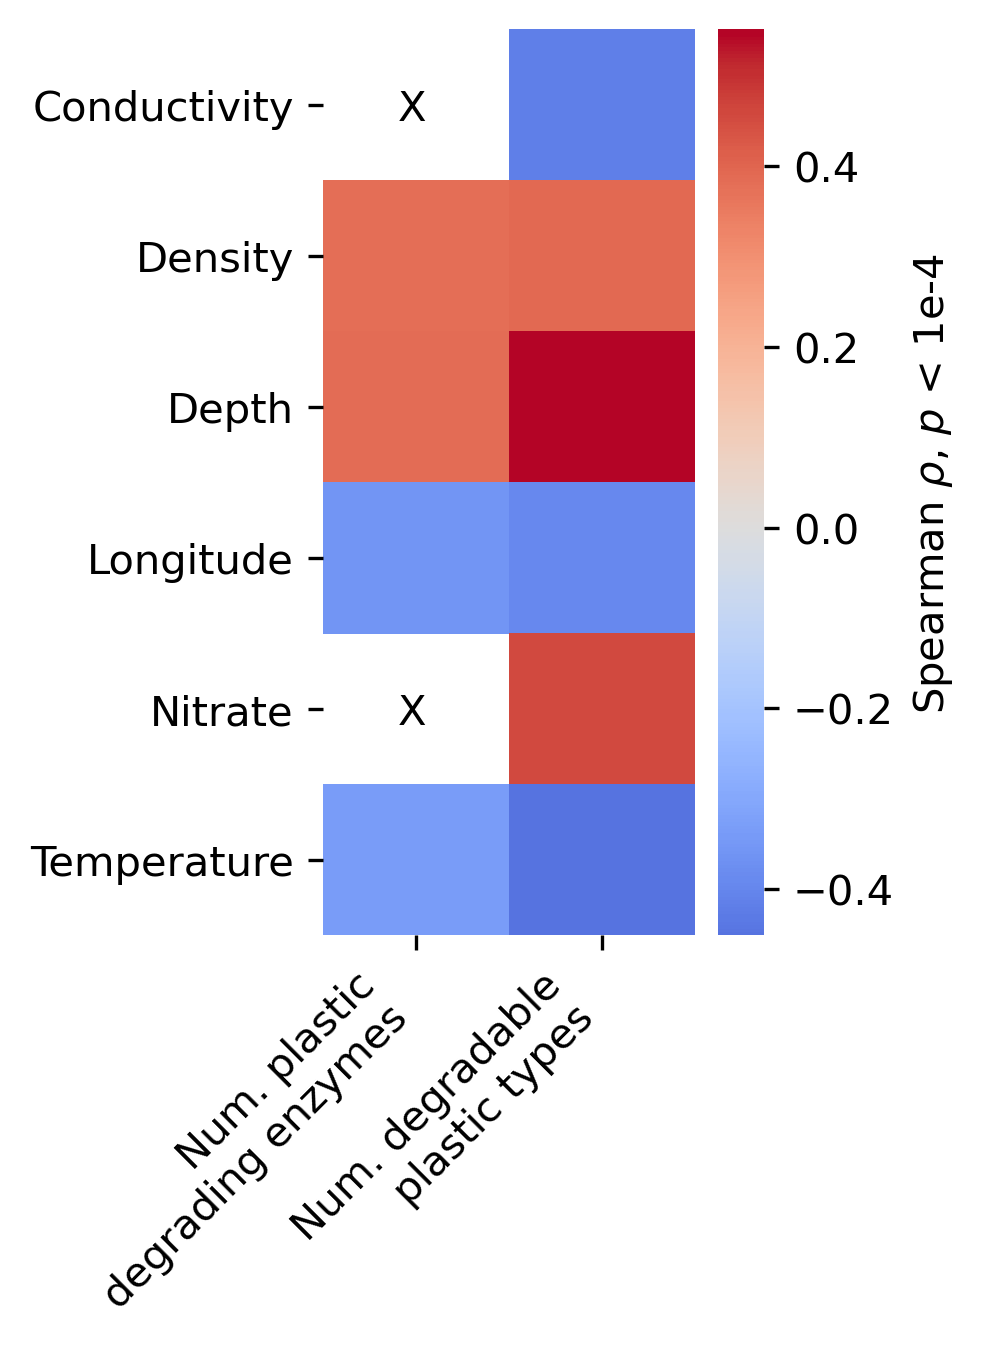

In [12]:
# plot this heatmap
dic_x = {'num_hits':label_hits_n,
         'pl_richness':label_plast_n
        }

# get data to df 
data = (df_pcc        
        .query('x.isin(["num_hits","pl_richness"])')
        .replace({'x':dic_x})
        .pivot(index='x',columns='y',values='r')
        .transpose()
       )
data

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(2,4))
sns.heatmap(data[[label_hits_n,label_plast_n]], # ordering
            cmap='coolwarm',
            center=0,
            cbar_kws={'label': "Spearman "+r'$\rho$, $p$ < 1e-4',
                    },
           )
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45,ha='right')
plt.yticks(rotation=0,ha='right')
#plt.title('$p$ < 1e-4')

# plot xs for variables that are not below p-val cutoff
plt.annotate('X',xy=(0.4,0.6))
plt.annotate('X',xy=(0.4,4.6))

plt.show()


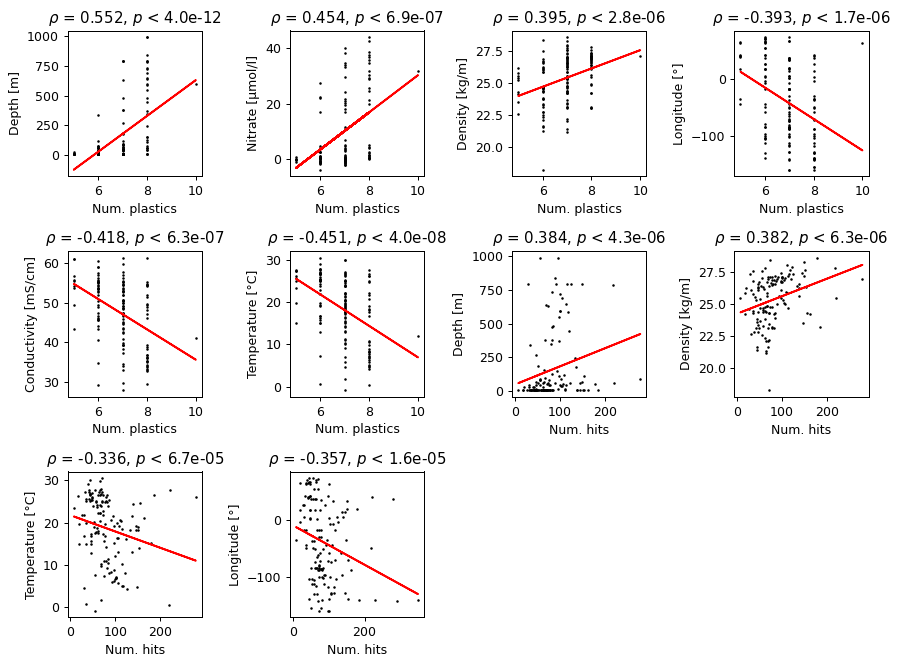

In [13]:
# Plot all correlations subplot
dic_x = {'num_hits': 'Num. hits',
         'pl_richness': 'Num. plastics'
        }

mpl.rcParams['figure.dpi'] = 90
dic_env_inv = {v: k for k, v in dic_env.items()}
data = (df_rich
 .merge(df_env,
        on=col,how='left')
)
tmp = (df_pcc        
        .query('x.isin(["num_hits","pl_richness"])')
        .replace({'x':dic_x})
        .sort_values(by='x',ascending=False)
)

mpl.rcParams['figure.dpi'] = 90
plt.figure(figsize=(10,7.5))
k=1
for idx,row in tmp.iterrows():
    
    plt.subplot(3,4,k)
    var1 = df_pcc.loc[idx].x
    var2 = dic_env_inv[df_pcc.loc[idx].y]
    x = data[[var1,var2]].dropna()[var1] 
    y = data[[var1,var2]].dropna()[var2]

    slope, intercept, rvalue, pvalue, stderr = stats.linregress(x,y)
    plt.scatter(x,y,s=1,alpha=1,c='k',label='original data')
    plt.plot(x, slope*x+intercept, 'r', label='fitted line')
    plt.xlabel(row.x)
    plt.ylabel(dic_env2[var2])
    plt.title(r'$\rho$ = '+str("%.3f" % corr_f(x,y)[0])+
            ', $p$ < '+str("%.1e" % fix_pvals(corr_f(x,y)[1])))
    k+=1
    
plt.tight_layout()
plt.show()

### Pollution data

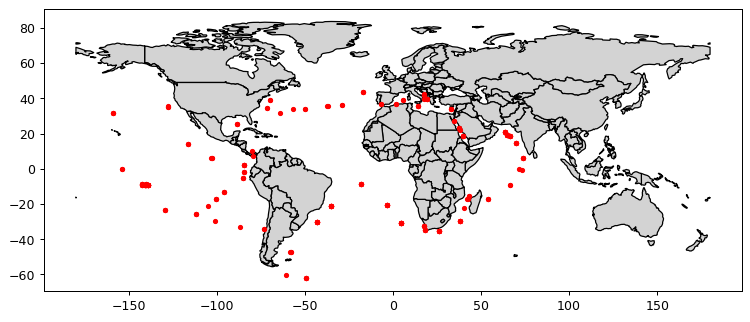

In [14]:
#https://geopandas.org/mapping.html
#https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world.name!="Antarctica")]

# fit tara location data to geo-data stucture
geometry = [Point(xy) for xy in zip(tara_metadata['longitude'],
                                     tara_metadata['latitude'])]

geo_df = (gpd
          .GeoDataFrame(tara_metadata[col],
                          geometry=geometry)
         )
# plot
mpl.rcParams['figure.dpi'] = 90
fig,ax = plt.subplots(figsize=(10,10))
world.plot(ax=ax,color='lightgrey', edgecolor='k')
geo_df.plot(ax=ax,marker='o',color='r',markersize=10)
plt.show()

In [15]:
# load pollution data
df_pol = []

# Total Pieces/L, global
df_pol.append(pd
              .read_excel('../data/WW Marine Datashare.xlsx',sheet_name='Q1')
              .rename(columns={'Sample Longitude':'longitude',
                               'Sample Latitude':'latitude',
                               'Total Pieces/L':'conc'
                              })
             )
df_pol[-1]['dataset'] = 'adventure'

# g/km2, global
df_pol.append(pd
              .read_excel('../data/PlasticMarinePollutionGlobalDataset_Eriksen2014.xlsx')
              .drop(0)
              .rename(columns={'Longitude':'longitude',
                               'Latitude':'latitude'})
             )
# merge concentrations across all plastic sizes
df_pol[-1]['conc'] = (df_pol[-1]['WD1 (g/km^2)'].fillna(0)+
                       df_pol[-1]['WD2 (g/km^2)'].fillna(0)+
                       df_pol[-1]['WD3 (g/km^2)'].fillna(0)+
                       df_pol[-1]['WD4 (g/km^2)'].fillna(0))
df_pol[-1]['dataset'] = 'eriksen2014'

# pieces/km2, this is only pacific
df_pol.append(pd.read_csv('../data/Pacific_Law_plastics.txt',
                      delim_whitespace=True,skiprows=1,
                     names=['month','day','year','longitude','latitude','conc']))
df_pol[-1]['dataset'] = 'law2014'

# mg/m³, only north pacific
df_pol.append(pd
              .read_csv('../data/MicroplasticNumericalandMassConcentration_Goldstein2012.csv')
                .rename(columns={'Longitude (º)':'longitude',
                                 'Latitude (º)':'latitude',
                                 'Microplastic Mass (mg/m³)':'conc'})
             )
df_pol[-1]['dataset'] = 'goldstein2012'

# standardize
for d in df_pol:
    a,_ = stats.boxcox([x+1 for x in normalize(d.conc.values)])
    d['conc_box_zscore'] = preprocessing.scale(a)

In [16]:
# make geo dfs
geo_df_pol = []
for x in df_pol:    
    geo_df_pol.append(gpd.GeoDataFrame(x[['conc_box_zscore','dataset']],
                          geometry=[Point(xy) for xy in zip(x['longitude'],
                                        x['latitude'] )])
                     )
print([len(x) for x in geo_df_pol])

# for our sample points find closest points
geo_df_near = []
for x in geo_df_pol:
    geo_df_near.append(ckdnearest(geo_df, x))

geo_df_near = pd.concat(geo_df_near)
geo_df_near['dist'] = geo_df_near.dist*100 # dist in km
print(geo_df_near.shape)

# prokaryote enriched fraction + surface fraction only
tmp = (tara_metadata[(tara_metadata.size_id.isin(['0.22-1.6','0.22-3']))
              &(tara_metadata.depth_id=='SRF')][col])
# remove nan datasets
geo_df_near = (geo_df_near
               .dropna(subset=['dataset'])
               .query('group_id.isin(@tmp)')
              )
print(geo_df_near.shape)
geo_df_near.head()

[1393, 1571, 2529, 235]
(972, 5)
(248, 5)


,group_id,geometry,conc_box_zscore,dataset,dist
1,ERR598955|ERR599003,POINT (-6.56690 36.55330),0.787171,adventure,74.886805
3,ERR315857,POINT (1.93780 37.05100),0.630741,adventure,386.656035
5,ERR594288|ERR594316|ERR594317,POINT (5.91600 39.16330),0.630741,adventure,163.645511
8,ERR598993|ERR599140,POINT (14.25740 35.75900),-0.069297,adventure,245.910565
13,ERR315858|ERR315861,POINT (17.71500 42.20380),-0.069297,adventure,114.145692


In [17]:
# Correlation analysis, sensitivity analysis

def get_pcc(itr,corr_f=corr_f,col=col):
    d = itr[2]
    tmp = (itr[-1][itr[-1].dataset.isin(itr[3])]
           .query('dist<=@d')
           .drop(columns=['geometry'])
           .sort_values(by=[col,'dist'],ascending=True) # we are keeping only the first closest point per location
           .drop_duplicates(subset=col,keep='first')
          )
    r,p = corr_f(tmp[itr[0]],tmp[itr[1]])
    return itr[0],itr[1],itr[2],len(itr[3]),r,p,tmp[col].unique().shape[0],itr[3]

data = (geo_df_near.merge(df_rich[['num_hits',col]],
                        on=col,
                         how='left').dropna()
  .merge(tara_metadata[[col,'ocean','ocean_long']],
           on=col,how='left')
        )
print(data[col].unique().shape)

dists = list(range(100,1100,100))
pars = [['conc_box_zscore',
         'num_hits',d,
         ['adventure','eriksen2014','goldstein2012','law2014'],
         data] for d in dists]
pcc = (pd.DataFrame(list(map(get_pcc,pars)),
                   columns=['var1','var2','dist','num_dsets','r','p','n','dsets'])
       .query('p<0.05')
       .sort_values(by='r',ascending=False)
      )

# sensitivity analysis with distance
pcc.sort_values(by='dist')[['dist','r','p','n']].reset_index(drop=True).query('dist.isin([100,200,300,400,500,700,1000])')

(63,)


,dist,r,p,n
0,300,0.384640,0.024696,34
1,400,0.491861,0.001090,41
2,500,0.461590,0.001611,44
4,700,0.345411,0.013046,51
7,1000,0.297265,0.029040,54


In [18]:
# average num points per dataset
tmp = []
for d in [100,200,300,400,500,700,1000]:
    dat = pd.DataFrame(data.query('dist<=@d')
               .sort_values(by=[col,'dist'],ascending=True)
               .drop_duplicates(subset=col,keep='first')
          .groupby('dataset').conc_box_zscore.count()
    )
    dat['dist_cut'] = d
    tmp.append(dat)

pd.concat(tmp).groupby('dist_cut').mean().mean()

conc_box_zscore    9.607143
dtype: float64

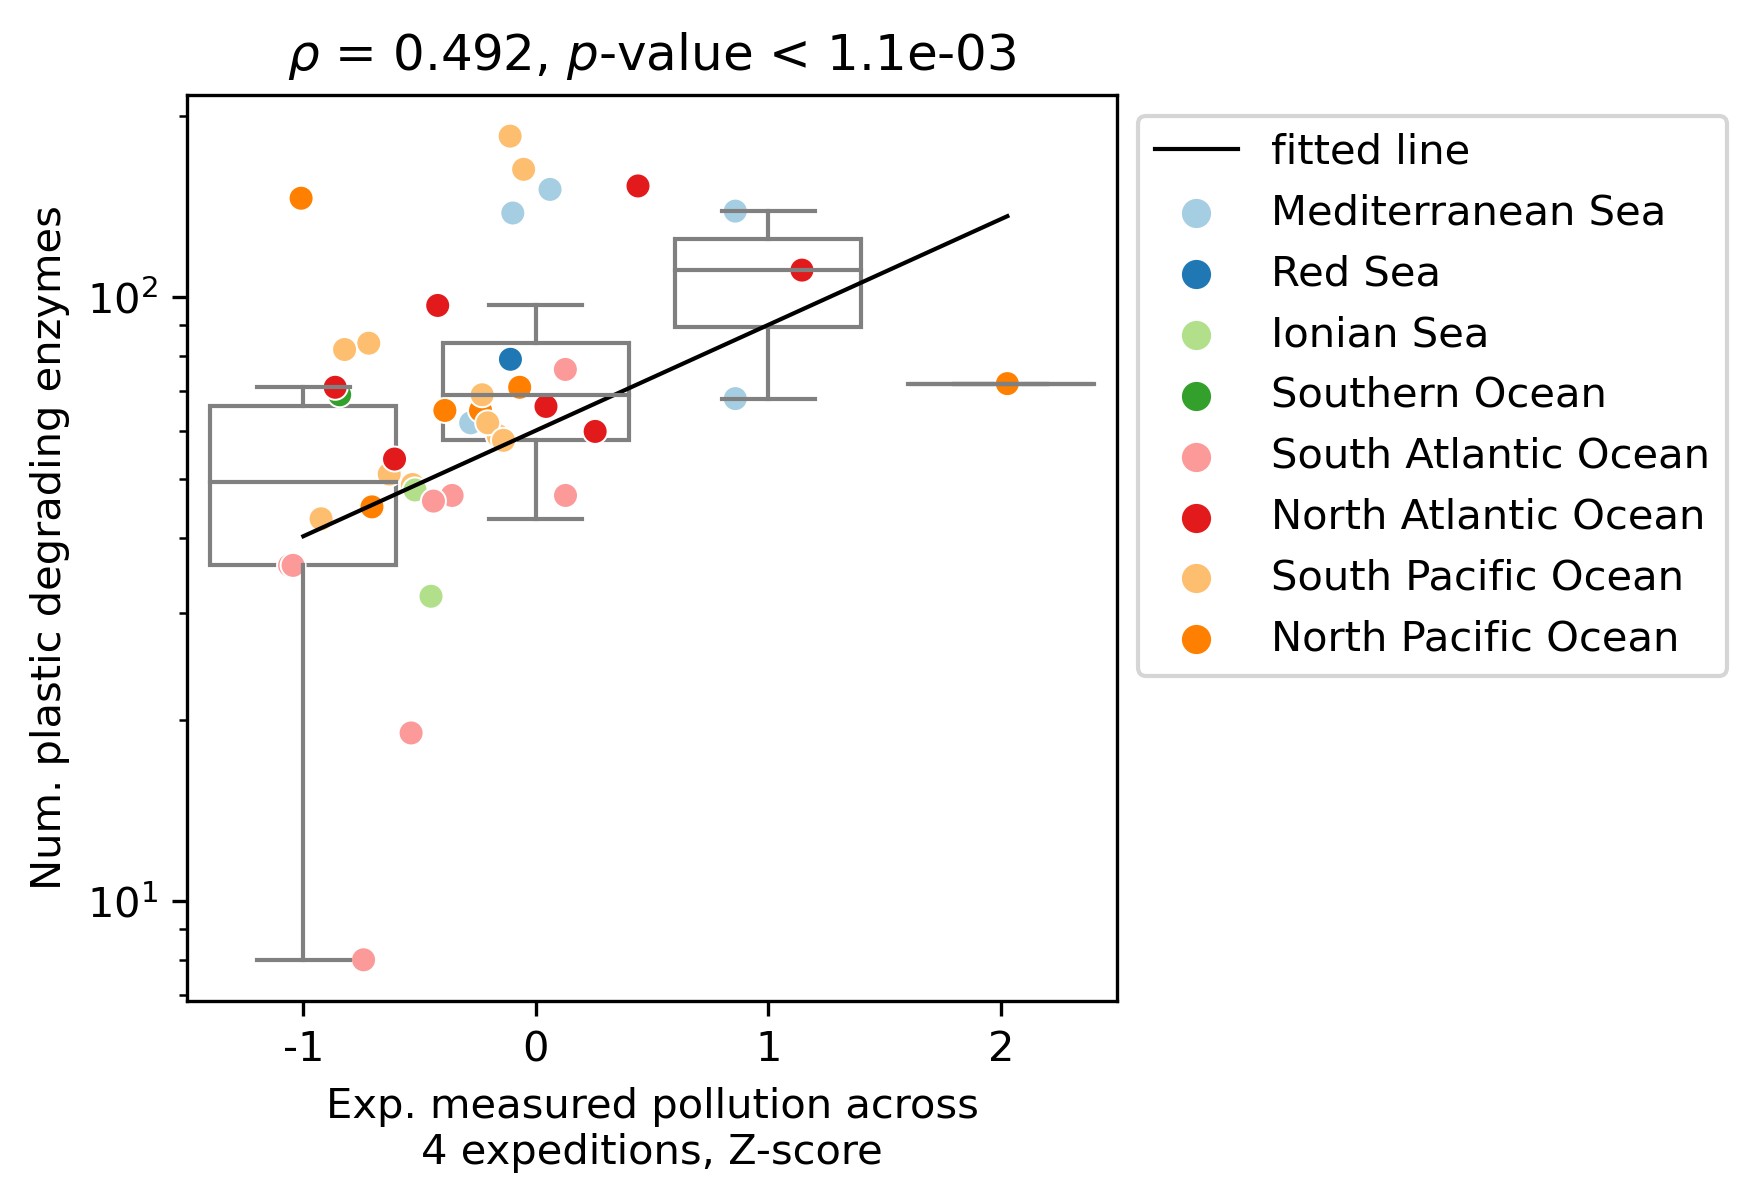

In [19]:
# plot
dist = 400
np.random.seed(2222)

# distribution of enzyme-hits for strata of pollution level
x = (data.query('dist<=@dist')
     .sort_values(by=[col,'dist'],ascending=True)
     .drop_duplicates(subset=col,keep='first')
     ['conc_box_zscore']
     .apply(lambda x: x+1) 
     .values)
y = (data.query('dist<=@dist')
     .sort_values(by=[col,'dist'],ascending=True)
     .drop_duplicates(subset=col,keep='first')
     ['num_hits'].values)
env = (data.query('dist<=@dist')
     .sort_values(by=[col,'dist'],ascending=True)
     .drop_duplicates(subset=col,keep='first')
     ['ocean_long'].values)
x2 = np.round(x)
cor = corr_f(x,y)

x = [xx+np.random.uniform(-0.5, 0.5) for xx in x]

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(4,4))

ax = sns.boxplot(data=pd.DataFrame([x2,y]).transpose().rename(columns={0:'x',1:'y'}),
           x='x',y='y',color='white',#orient='h',
           fliersize=0)
plt.setp(ax.artists, edgecolor = '.5', facecolor='w', linewidth=1)
plt.setp(ax.lines, color='.5', linewidth=1)

sns.scatterplot(data=(pd.DataFrame([x,y,env])
                           .transpose()
                           .rename(columns={0:'x',1:'y',2:'ocean_long'})
                          ),
                x='x',y='y',
              hue='ocean_long',
                hue_order=df_ocean.long.tolist(),
                 color='k',palette=palett)

# # line fit semi-log scale
p1 = np.polyfit(x, y, 1)
p1 = stats.siegelslopes(y, x, method='hierarchical')
p2 = np.polyfit(x, y, 2)
plt.plot((0,max(x)), (p1[1],max(x)*p1[0]+p1[1]), 'k', linewidth=1, label='fitted line')

plt.xlabel('Exp. measured pollution across\n4 expeditions, Z-score')
plt.ylabel('Num. plastic degrading enzymes')
plt.title(r'$\rho$ = '+str("%.3f" % cor[0])+
          ', $p$-value < '+str("%.1e" % fix_pvals(cor[1])))
plt.xticks(ticks=[0,1,2,3],labels=[-1,0,1,2])
plt.yscale('log')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

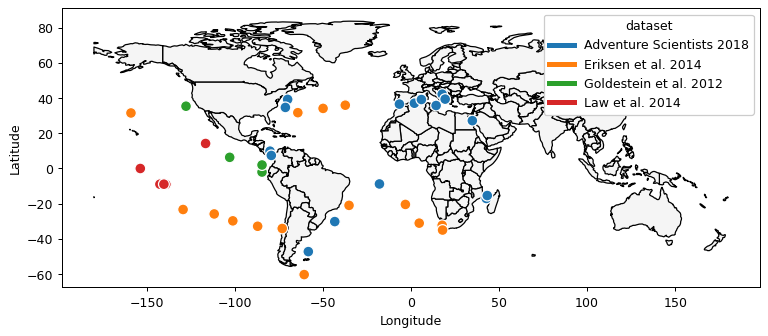

(8,)


In [20]:
# plot sampling locations on world map

d = 400
random.seed(1111)
mpl.rcParams['figure.dpi'] = 90
dset_dic = dict(zip(data.dataset.sort_values().unique(), 
                   {'Adventure Scientists 2018', 
                    'Eriksen et al. 2014',
                    'Goldestein et al. 2012',
                    'Law et al. 2014',
                   }))

# make geodf
df_plot = (data.query('dist<=@d')
               .sort_values(by=[col,'dist'],ascending=True)
               .drop_duplicates(subset=col,keep='first')
               .sort_values(by='dataset')
)
geo_df = gpd.GeoDataFrame(df_plot[['dataset']],
                          geometry=df_plot.geometry)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world.name!="Antarctica")]

# map color to grouping var
pal = sns.color_palette("tab10",geo_df.dataset.unique().shape[0])
dic2 = dict(zip(geo_df.dataset.sort_values().unique(), pal))
geo_df['dataset_color'] = geo_df.dataset.sort_values().map(dic2) 

# plot
fig,ax = plt.subplots(figsize=(10,10))
world.plot(ax=ax,color='whitesmoke', edgecolor='k')
geo_df.plot(ax=ax,marker='o',
            c=geo_df.dataset_color,
            markersize=75,
            edgecolor='w')

custom_lines = [Line2D([0],[0],color=pal[x],lw=4) for x in range(len(geo_df.dataset.sort_values().unique()))]
plt.legend(custom_lines, geo_df.replace({'dataset':dset_dic}).dataset.sort_values().unique(),
          bbox_to_anchor=(1,1),
          title='dataset',
          facecolor='white', framealpha=1)

plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

# How many oceans
print(df_plot.ocean_long.unique().shape)

### Principal coordinate analysis

(99, 139)
PC1  PC1    0.252226
PC2  PC2    0.139046
dtype: float64


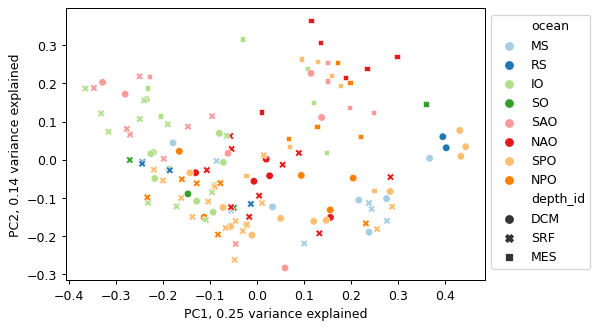

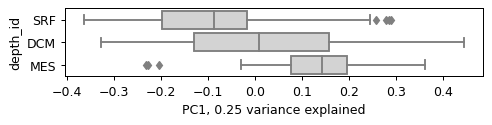

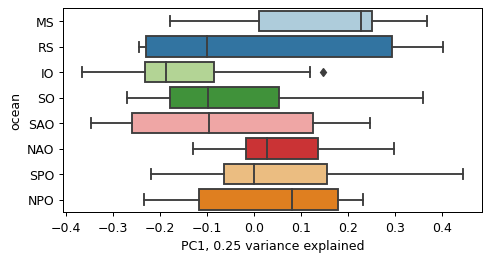

In [21]:
# BIOM table of hits per hmm_model vs samples
denom = (dfs
 .groupby(['hmm_model',col])
 .target_name.count()
 .rename('counts')
 .reset_index()
 .query('counts>0')
 .counts.min()
)

df_biom = (dfs
 .groupby(['hmm_model',col])
 .target_name.count()
 .rename('counts')
 .divide(denom)
 .round().astype(int)
 .unstack()
 .fillna(0)
)
print(df_biom.shape)

# invert PC1 to account for inversion in pcoa
# distance matrix
bc_dm = table_to_distances(df_biom, bray_curtis_distance)

# perform pcoa
bc_dm_pc = pcoa(bc_dm)
bc_dm_pc.samples = 0-bc_dm_pc.samples

# variance explained
tmp = bc_dm_pc.samples.cov()
tmp = pd.Series(np.diag(tmp), index=[tmp.index, tmp.columns])
sum(tmp/sum(tmp))
tmp = tmp/sum(tmp)
print(tmp[:2])

mpl.rcParams['figure.dpi'] = 90
sns.scatterplot(data=bc_dm_pc.samples #gets df from pcoa
                .merge(tara_metadata
               .set_index(col)
               .loc[bc_dm_pc.samples.index,['ocean','depth_id']],
               left_index=True,right_index=True,
               how='left'),
                x='PC1',y='PC2',
                hue='ocean',
                hue_order=ocean_order,
                palette=palett,
                style='depth_id',
               )
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('PC1, %.2f variance explained'%(tmp.iloc[0]))
plt.ylabel('PC2, %.2f variance explained'%(tmp.iloc[1]))
plt.show()

# 
plt.figure(figsize=(6,1))
sns.boxplot(data=bc_dm_pc.samples #gets df from pcoa
                .merge(tara_metadata
               .set_index(col)
               .loc[bc_dm_pc.samples.index,['ocean','depth_id']],
               left_index=True,right_index=True,
               how='left'),
           x='PC1',y='depth_id',color='lightgrey',
            order=['SRF','DCM','MES'])
plt.xlabel('PC1, %.2f variance explained'%(tmp.iloc[0]))
plt.show()

plt.figure(figsize=(6,3))
sns.boxplot(data=bc_dm_pc.samples #gets df from pcoa
                .merge(tara_metadata
               .set_index(col)
               .loc[bc_dm_pc.samples.index,['ocean','depth_id']],
               left_index=True,right_index=True,
               how='left'),
            x='PC1',y='ocean',
            order=ocean_order,
            palette=palett,
           )
plt.xlabel('PC1, %.2f variance explained'%(tmp.iloc[0]))
plt.show()

8_Latitude of event (Latitude) SpearmanrResult(correlation=0.24570830433491397, pvalue=0.003550832547773316)
9_Longitude of event (Longitude) SpearmanrResult(correlation=-0.34170057129664644, pvalue=3.841261990119062e-05)
18_Depth, reference [m] (Depth ref) SpearmanrResult(correlation=0.452774004425316, pvalue=3.514612926096278e-08)
19_Conductivity [mS/cm] (Cond) SpearmanrResult(correlation=-0.36025525298325617, pvalue=2.205331958623224e-05)
20_Salinity (Sal) SpearmanrResult(correlation=-0.028416087492299236, pvalue=0.7463649661602219)
21_Temperature, water, potential [°C] (Tpot) SpearmanrResult(correlation=-0.4199200078041167, pvalue=3.977421119586487e-07)
22_Density, sigma-theta (0) [kg/m SpearmanrResult(correlation=0.46179292784355047, pvalue=2.4979198316661228e-08)
23_Oxygen [µmol/kg] (OXYGEN) SpearmanrResult(correlation=-0.06974535050528313, pvalue=0.4340434841848768)
25_Nitrate [µmol/l] ([NO3]-) SpearmanrResult(correlation=0.39433878773803294, pvalue=2.2074264626620905e-05)
27_Ph

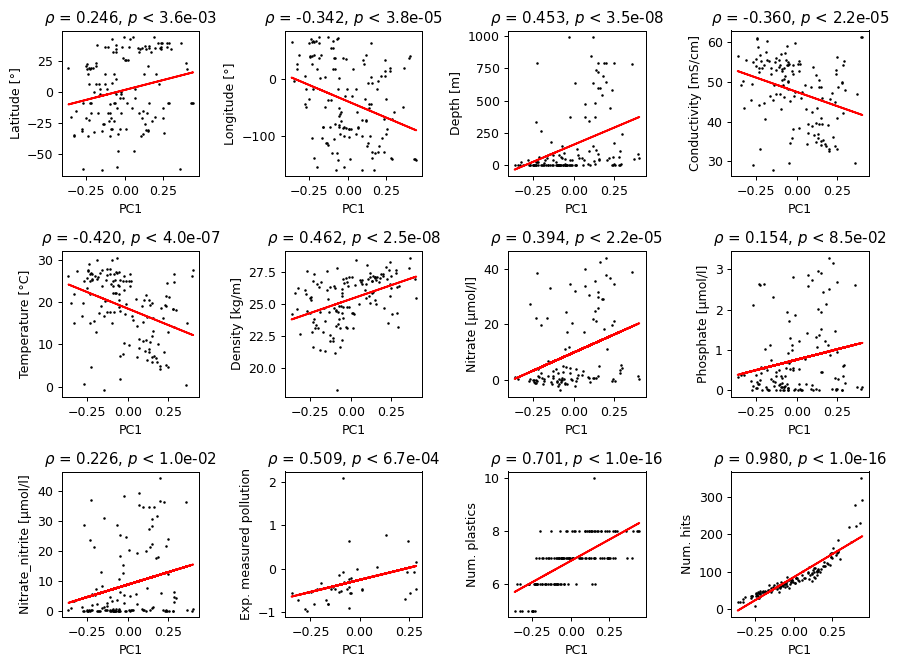

In [22]:
# check PC1 vs environment variables + pollution

col_env2 = col_env.copy()
data = (bc_dm_pc.samples
        .merge(df_env
               .set_index(col)
               .loc[bc_dm_pc.samples.index,col_env],
               left_index=True,right_index=True,
               how='left')
        .reset_index().rename(columns={'index':col})
        .merge(df_rich[[col,'pl_richness','num_hits']],on=col,how='left')
        .merge(geo_df_near
               .query('dist<=@dist')
               .sort_values(by=[col,'dist'],ascending=True)
               .drop_duplicates(subset=col,keep='first')
               [['group_id','conc_box_zscore']],
           on=col,how='left')
)
data

# to check
col_env2.extend(['conc_box_zscore','pl_richness','num_hits']) 
dic_env2['conc_box_zscore'] = 'Exp. measured pollution'
dic_env2['num_hits'] = 'Num. hits'
dic_env2['pl_richness'] = 'Num. plastics'

mpl.rcParams['figure.dpi'] = 90
plt.figure(figsize=(10,7.5))
k=1
for c in col_env2:
    x = data[['PC1',c]].dropna().PC1.values
    y = data[['PC1',c]].dropna()[c].values
    
    print(c, corr_f(x,y))
    
    if corr_f(x,y)[1] < 1e-1:
        plt.subplot(3,4,k)
        slope, intercept, rvalue, pvalue, stderr = stats.linregress(x,y)
        plt.scatter(x,y,s=1,alpha=1,c='k',label='original data')
        plt.plot(x, slope*x+intercept, 'r', label='fitted line')
        plt.xlabel('PC1')
        plt.ylabel(dic_env2[c])
        plt.title(r'$\rho$ = '+str("%.3f" % corr_f(x,y)[0])+
                  ', $p$ < '+str("%.1e" % fix_pvals(corr_f(x,y)[1])))
        k+=1
    
plt.tight_layout()
plt.show()

# MAGs analysis

In [23]:
# setup R session
%load_ext rpy2.ipython
%R .libPaths(c('/home/zrimec/miniconda3/envs/plastics/lib/R/library'))
               #,'/usr/local/lib/R/site-library','/usr/lib/R/site-library','/usr/lib/R/library','/home/zrimec/R/x86_64-conda_cos6-linux-gnu-library/3.6'))

#%R install.packages('stringi')

array(['/home/zrimec/miniconda3/envs/plastics/lib/R/library',
       '/usr/local/lib/R/site-library', '/usr/lib/R/site-library',
       '/usr/lib/R/library'], dtype='<U51')

In [24]:
# load data
dfa = pd.read_csv('../data/tara_mags_parsed.csv').rename(columns={'e-value':'e_value'})
dfa.shape

# filter 
dfa = dfa.query("label=='tara'")

# make list and get long df on inscd_run
tara_metadata['inscd_run'] = (tara_metadata.run
                               .apply(lambda x: x.split('|'))
                              )
tara_long = dframe_stack_list(tara_metadata[['inscd_run','inscd_id',
                                     'depth_id','size_id','ocean']],
                      'inscd_run',typ='str')

# prokaryote enriched fraction
tmp = (tara_metadata[(tara_metadata.size_id.isin(['0.22-1.6','0.22-3']))]
       .inscd_id)

# merge metadata
dfa['sample_id'] = (dfa.target_name
                     #.apply(lambda x: x.split('|')[1][:6])
                     .apply(lambda x: x.split('_')[0].split('.')[0])
                    )
dfa = (dfa
        .merge(tara_long[['inscd_run','inscd_id','depth_id','size_id','ocean']],
                left_on='sample_id',
                right_on='inscd_run',
                how='left')
     )
    
# also drop na values where runs
dfa.dropna(subset=['inscd_id'],inplace=True)

# select sub-fraction
dfa = dfa[dfa.inscd_id.isin(tmp)]
dfs = dfa.query('e_value<=@e_cut')
print(dfs.shape)
print(dfa.inscd_id.unique().shape)
print(dfa.inscd_run.unique().shape)

(10762, 28)
(135,)
(243,)


In [25]:
# load/parse GTDBtk stats
cols = ['filename','tax1']
cols2 = ['domain','phylum','class',
        'order','family','genus','species']   

df_gtdb = pd.read_csv('../data/GTDBtk.stats',
            usecols=[0,1],
            sep='\t',names=cols)

tmp = (df_gtdb.tax1
 .str.replace('d__','')
 .str.replace('p__','')
 .str.replace('c__','')
 .str.replace('o__','')
 .str.replace('f__','')
 .str.replace('g__','')
 .str.replace('s__','')
 .str.split(';')
 .tolist()
)
df_gtdb = pd.concat([df_gtdb,pd.DataFrame(tmp,columns=cols2)],axis=1)
print(df_gtdb.shape)

# num. species not present
print(sum(df_gtdb.species.apply(lambda x: x=='')))

# set ids
df_gtdb['inscd_run'] = df_gtdb.filename.apply(lambda x: x.split('.')[0])
df_gtdb.head()

(9371, 9)
3706


,filename,tax1,domain,phylum,class,order,family,genus,species,inscd_run
0,ERR1701760.bin.32.permissive,d__Archaea;p__Nanoarchaeota;c__Nanoarchaeia;o_...,Archaea,Nanoarchaeota,Nanoarchaeia,UBA10117,ARS21,ARS21,ARS21 sp002686215,ERR1701760
1,ERR1701760.bin.21.permissive,d__Archaea;p__Thermoplasmatota;c__Poseidoniia;...,Archaea,Thermoplasmatota,Poseidoniia,Poseidoniales,Thalassoarchaeaceae,MGIIb-O5,MGIIb-O5 sp002505775,ERR1701760
2,ERR1701760.bin.16.permissive,d__Archaea;p__Thermoplasmatota;c__Poseidoniia;...,Archaea,Thermoplasmatota,Poseidoniia,Poseidoniales,Thalassoarchaeaceae,MGIIb-O3,MGIIb-O3 sp001628485,ERR1701760
3,ERR1701760.bin.25.permissive,d__Archaea;p__Thermoplasmatota;c__Poseidoniia;...,Archaea,Thermoplasmatota,Poseidoniia,Poseidoniales,Thalassoarchaeaceae,MGIIb-O2,MGIIb-O2 sp002686525,ERR1701760
4,ERR1701760.bin.27.strict,d__Archaea;p__Thermoplasmatota;c__Poseidoniia;...,Archaea,Thermoplasmatota,Poseidoniia,Poseidoniales,Thalassoarchaeaceae,MGIIb-O1,MGIIb-O1 sp002685415,ERR1701760


In [26]:
# merge 
dfs.target_name.unique()
dfs['filename'] = (dfs
                   .target_name
                   .apply(lambda x: x.split('_')[0][:-3])
                  )
dfs.filename

df = (dfs[['filename','inscd_run','inscd_id','hmm_model','plastic','depth_id','ocean',
               'auc_cut','seqid','prec_cut']]
 .merge(df_gtdb.drop(columns=['inscd_run','tax1']),
        on='filename',how='left')
        )

# define new phylum where Proteobacteria phylum defined at class level same as in Bork2013
df['phylum2'] = df.phylum
df.at[df.phylum=='Proteobacteria','phylum2'] = df[df.phylum=='Proteobacteria']['class']
df.head()

# drop some values
to_drop = ['SAR324','AB1-6','UBA8248','UBP7_A','UAP2','UBP7','UBP17','']
df.drop(df[df.phylum.isin(to_drop)].index,inplace=True)
print(df.shape)

(10649, 18)


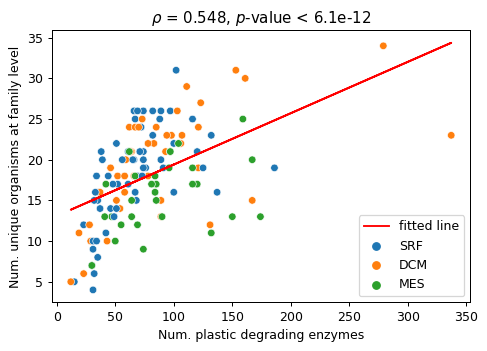

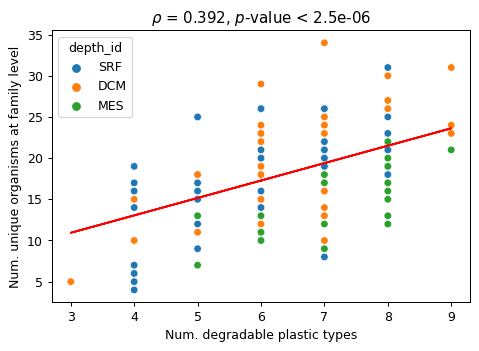

In [27]:
# num hits vs num speices
col='family'

data = (df
        .groupby(['inscd_id','depth_id'])
        .filename
        .count()
        .rename('num_hits')
        .reset_index()
 .merge(df
        .groupby(['inscd_id','depth_id'])
        [col]
        .nunique()
        .rename('spec_nunique')
        .reset_index(),on='inscd_id')
 .merge(df
        .groupby(['inscd_id','depth_id'])
        .plastic
        .nunique()
        .rename('plastic_nunique')
        .reset_index(),on='inscd_id')
)
data

#plt.figure(figsize=(4,3))
sns.scatterplot(data=data,
           x='num_hits',y='spec_nunique',hue='depth_id',
               )
plt.ylabel('Num. unique organisms at family level')
plt.xlabel(label_hits)

x = data.num_hits.values
y = data.spec_nunique.values
slope, intercept, rvalue, pvalue, stderr = stats.linregress(x,y)
plt.plot(x, slope*x+intercept, 'r', label='fitted line')

plt.title(r'$\rho$ = '+str("%.3f" % corr_f(x,y)[0])+
              ', $p$-value < '+str("%.1e" % fix_pvals(corr_f(x,y)[1])))
plt.legend(loc=4)
plt.show()

#plt.figure(figsize=(4,3))
sns.scatterplot(data=data,
           x='plastic_nunique',y='spec_nunique',hue='depth_id',
               )
plt.ylabel('Num. unique organisms at family level')
plt.xlabel(label_plast)

x = data.plastic_nunique.values
y = data.spec_nunique.values
slope, intercept, rvalue, pvalue, stderr = stats.linregress(x,y)
plt.plot(x, slope*x+intercept, 'r', label='fitted line')

plt.title(r'$\rho$ = '+str("%.3f" % corr_f(x,y)[0])+
              ', $p$-value < '+str("%.1e" % fix_pvals(corr_f(x,y)[1])))
plt.show()

### Num hits vs. num species

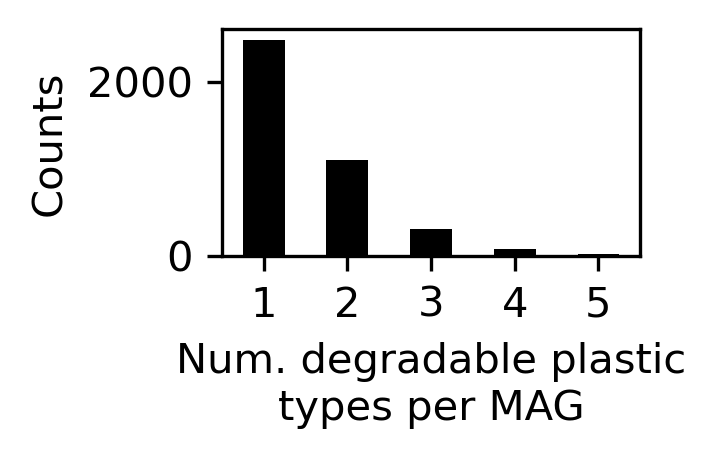

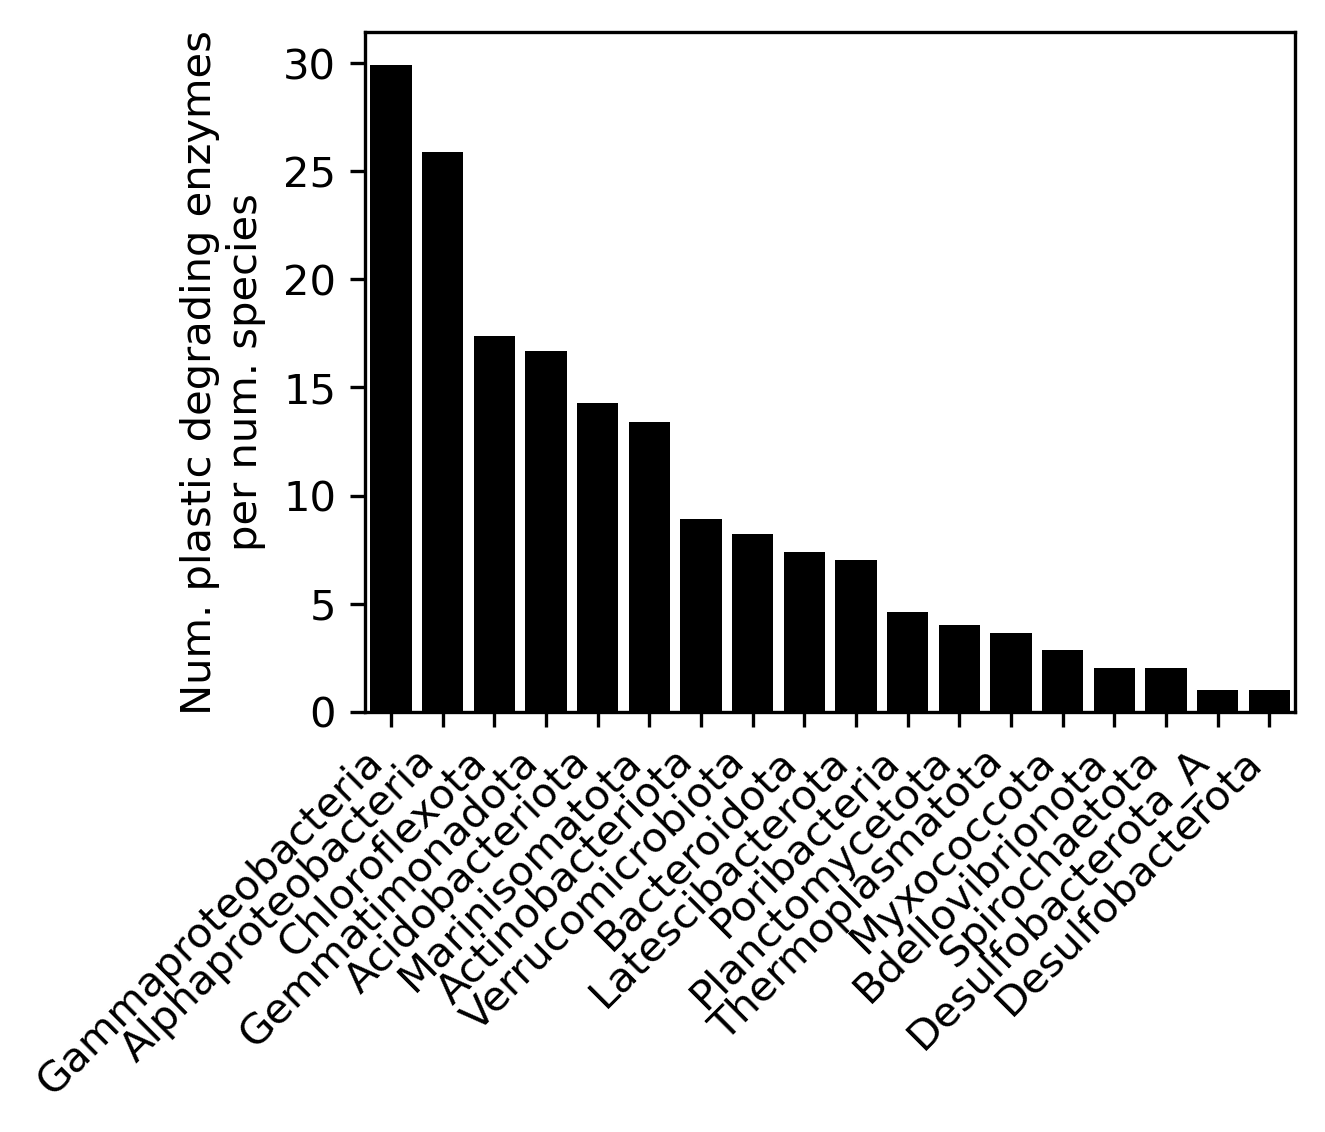

In [28]:
# top plastic degrading species
# hist num plastics per bin

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(1.8,1))
plt.hist((df
        .groupby(['filename'])
        .plastic
        .nunique()
        .rename('plastic_nunique')
        .reset_index()
       ).plastic_nunique,color='k')
plt.ylabel('Counts')
plt.xticks([x+0.25 for x in list(range(1,6))],
           [1,2,3,4,5])
plt.xlim(0.75,5.75)
plt.xlabel('Num. degradable plastic\ntypes per MAG')
plt.show()

plt.figure(figsize=(4,3))
sns.barplot(data=(df
        .groupby(['phylum2'])
        .filename
        .count()
        .divide(df
                .groupby(['phylum2'])
                .species
                .nunique())
         .rename('num_hits')
         .sort_values(ascending=False)
         .reset_index()
       ),
            x='phylum2',y='num_hits',
           color='k')
plt.ylabel('Num. plastic degrading enzymes\nper num. species')
plt.xlabel('')
plt.xticks(rotation=45,ha='right')
#plt.yscale('log')
plt.show()

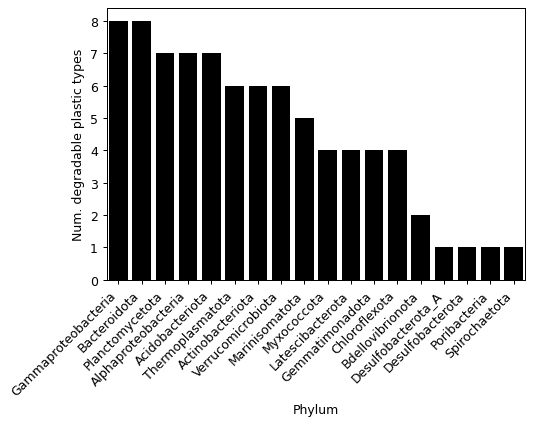

In [29]:
# supplementary figure
mpl.rcParams['figure.dpi'] = 90
sns.barplot(data=(df
        .groupby(['phylum2'])
        .plastic
        .nunique()
        .rename('plastic_nunique')
                  .sort_values(ascending=False)
        .reset_index()
       ),x='phylum2',y='plastic_nunique',
           color='k')
plt.ylabel(label_plast)
plt.xlabel('Phylum')
plt.xticks(rotation=45,ha='right')
plt.show()

In [30]:
# enrichment
data = pd.concat([(df
        .groupby(['phylum2'])
        .filename
        .count()
         .rename('num_hits')
       ),(df
                .groupby(['phylum2'])
                .species
                .nunique()
                .rename('num_species'))],axis=1)

# for each row compute enrichment vs others
enrich = []
for idx,row in data.iterrows():
    tmp = pd.concat([data.drop(idx).sum(),
                     data.loc[idx]],axis=1).transpose()
    _,p = stats.fisher_exact([tmp.iloc[1].values,tmp.iloc[0].values], alternative='greater')
    enrich.append([idx,row[0],row[1],p]) 
    
enrich = pd.DataFrame(enrich,columns=['phylum','num_hits',
                                      'num_species','p'])
enrich

,phylum,num_hits,num_species,p
0,Acidobacteriota,100,7,8.478952e-01
1,Actinobacteriota,464,52,9.999998e-01
2,Alphaproteobacteria,3706,143,1.364024e-05
3,Bacteroidota,288,39,9.999999e-01
4,Bdellovibrionota,10,5,9.999546e-01
5,Chloroflexota,696,40,7.915598e-01
6,Desulfobacterota,1,1,9.976172e-01
7,Desulfobacterota_A,1,1,9.976172e-01
8,Gammaproteobacteria,4461,149,2.530104e-12
9,Gemmatimonadota,167,10,7.520473e-01


In [31]:
# for text
data = (df
        .groupby(['filename'])
        .plastic
        .nunique()
        .rename('plastic_nunique')
        .reset_index()
)
(data
 .groupby('plastic_nunique')
 .count()
 .divide((data
 .groupby('plastic_nunique')
 .count()
).sum())
).iloc[3:].sum()

filename    0.024893
dtype: float64

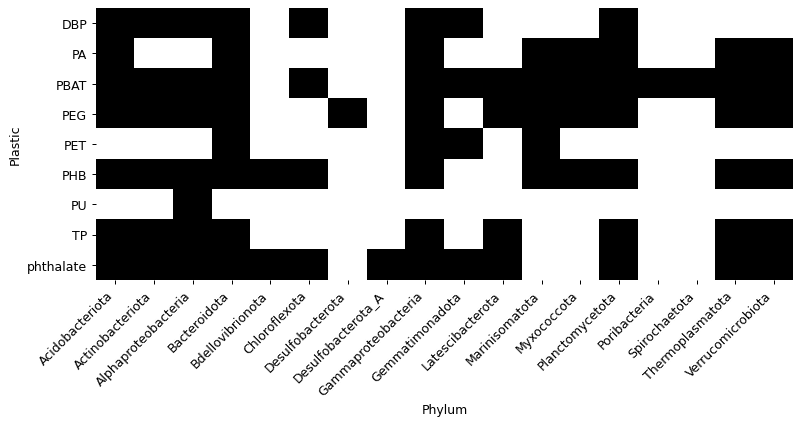

In [32]:
# plastics co-occurrence across species

plt.figure(figsize=(10,4))
data = df.drop_duplicates(subset=['phylum2','plastic'])
data['heatmap_amnt'] = 1
sns.heatmap(data=data.set_index(['plastic','phylum2']).heatmap_amnt.unstack().fillna(0),
           cbar=False,
           cmap=['w','k'])
plt.xticks(rotation=45,ha='right')
plt.ylabel('Plastic type richness')
#plt.legend().remove()
plt.ylabel('Plastic')
plt.xlabel('Phylum')
plt.show()